In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pickle

from model_cyl import Model
from simulation_cyl import FDTD_sim, extend_domain
from sources_cyl import *
from analysis_cyl import get_dB_response, get_frequency_response
from io_util import load_from_file, save_to_file

c:\Users\buijs\Documents\TUDelft\Masters Thesis\MastersThesis\.venv\Lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
# Use file browser to get file path
result_loaded = load_from_file()
if result_loaded is not None:
    result = result_loaded
    
    # unpack model dimensions
    model = result.model
    nr = result.model.nr
    nz = result.model.nz
    nt = result.model.nt
    dr = result.model.dr
    dz = result.model.dz
    dt = result.model.dt
    
    if result.sources[0].__class__.__name__ == "ParametricSource":
        delta_f = abs(result.sources[0].frequency1 - result.sources[0].frequency2)
    
print(model)

print(result.p.shape)
print(f"result.p: {result.p.nbytes/1e6} MB")
# del result

Model:
  nr=3000
  nz=5000
  dr=0.0017 m
  dz=0.0017 m
  nt=16500
  dt=3.5e-07 s
  domain_r=4.4166 m
  domain_z=7.14 m
  pml_width=400 / 0.6799999999999999 m
(1651, 260, 420)
result.p: 721.1568 MB


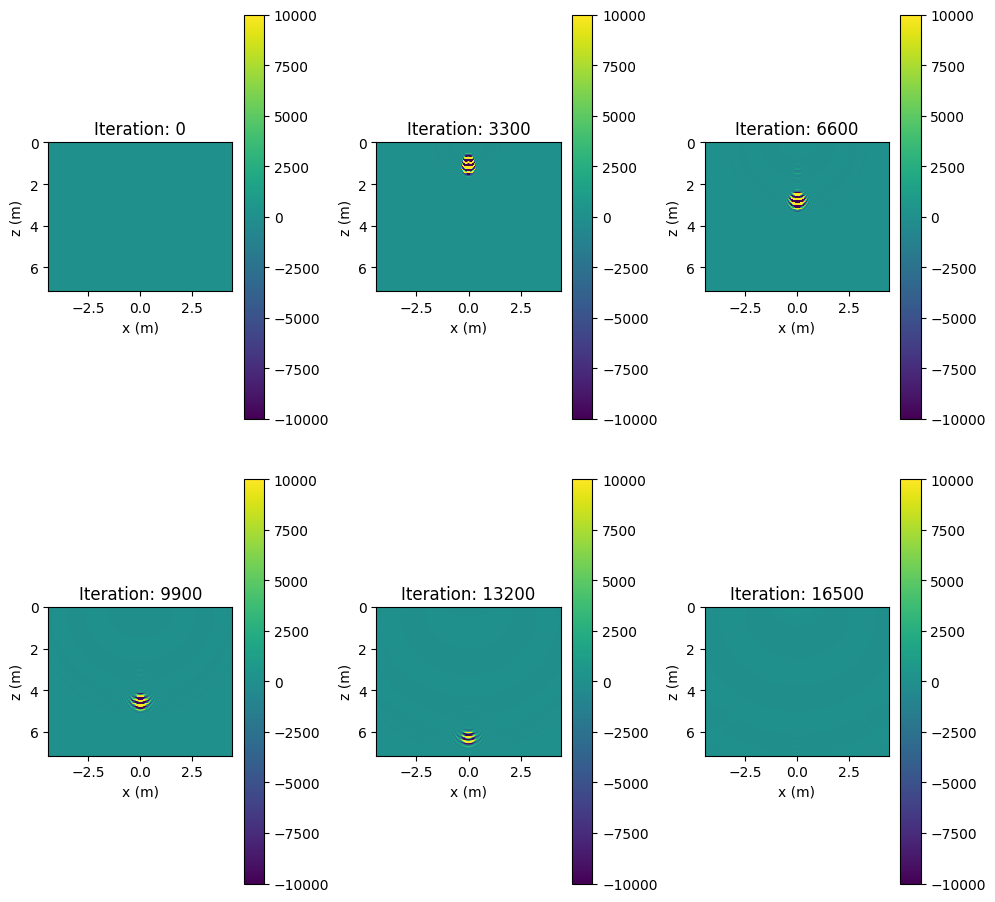

In [3]:
vlimit = 1e4
# plt.rcParams.update({"font.size": 10})
result.plot_snapshots(vlimit=vlimit, mirror=True)

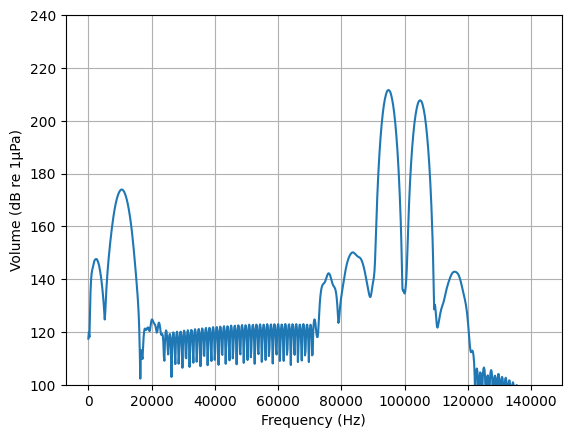

In [4]:
depth = 6  # m
ymin = 100
ymax = 240
# ymin = -100
# ymax = 5

r_index = 0
z_index = int(depth/dz/result.subsample_space)

plt.plot(*get_dB_response(np.pad(result.p[:, r_index, z_index], (0,0)), 
                          result.model.dt*result.subsample_time, 
                          result.sources[0].scaling_factor*result.subsample_time, 
                          normalize=False))
# plt.vlines(delta_f, ymin, ymax, "tab:blue", "--", alpha=1)

# colors = ["w", "tab:orange", "tab:green", "tab:red", "tab:purple"]
# for i in range(1,5):
#     plt.vlines(harmonics[i], ymin, ymax, colors[i], "--", alpha=1)


plt.xlabel("Frequency (Hz)")
# plt.ylabel("Normalized volume (dB)")
plt.ylabel("Volume (dB re 1\u00B5Pa)")
# plt.xlim(0,4*result.sources[0].frequency1)
# plt.xlim(0,5.5*result.sources[0].frequency1)
# plt.xlim(0,100000)
plt.ylim(ymin,ymax)
# plt.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
plt.grid()
plt.show()

100%|██████████| 3633/3633 [00:19<00:00, 183.92it/s]


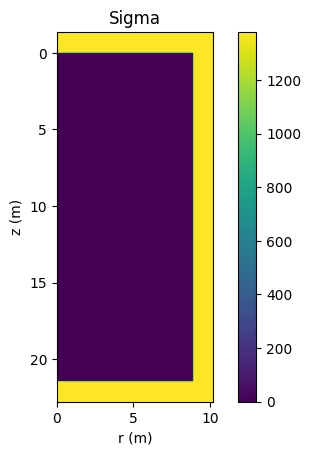

In [5]:
result = extend_domain(result, 
                       extend_from=13200//result.subsample_time, 
                       depth_multiplier=3, 
                       width_multiplier=2, 
                       cutoff=2*delta_f, 
                       additional_subsampling=3)

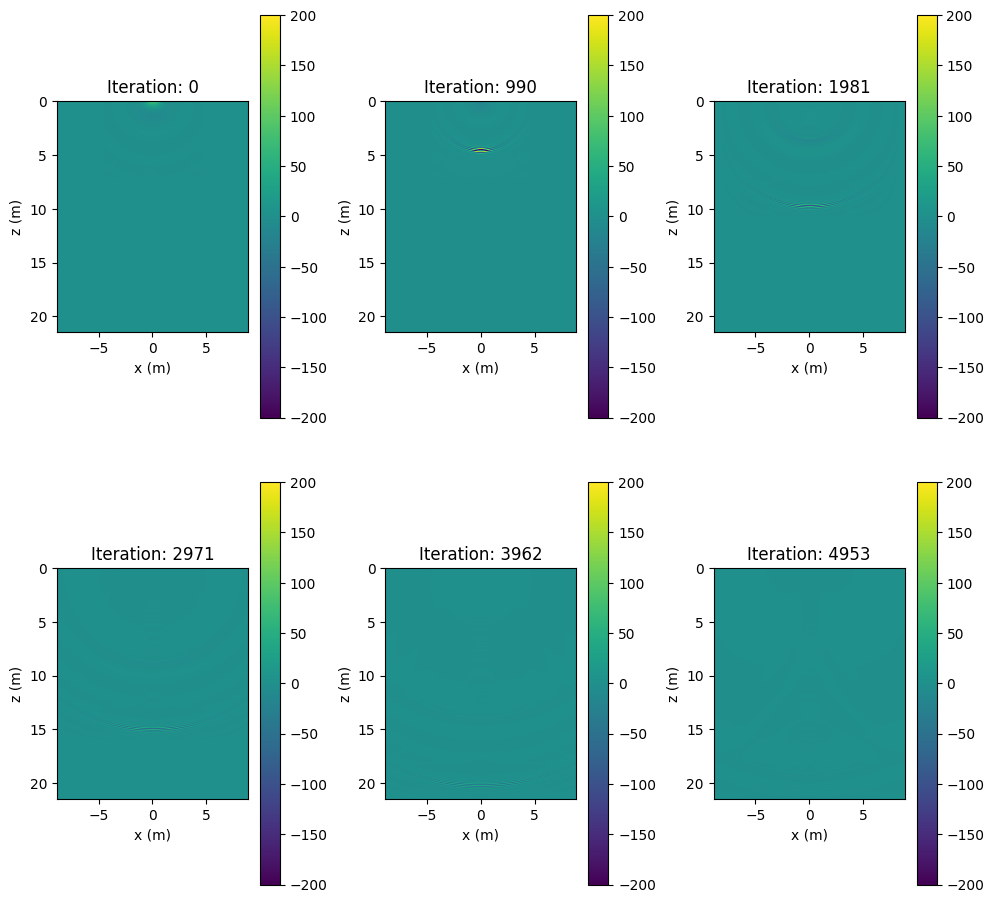

In [6]:
vlimit = 1e3
plt.rcParams.update({"font.size": 10})
result.plot_snapshots(vlimit=vlimit/5, mirror=True)

In [9]:
# # p_snapshot = result.p[12000//result.subsample_time//5]
# p_snapshot = result.p[5000//result.subsample_time]
# # p_snapshot = np.pad(p_snapshot, ((0,0), (0,2*p_snapshot.shape[1])), mode="constant", constant_values=np.nan)
# # print(p_snapshot.shape)
# p_mirrored = np.concatenate([np.flip(p_snapshot, axis=0), p_snapshot], axis=0)

# vlimit = 1e2
# plt.rcParams.update({"font.size": 22})
# plt.figure(figsize=(10,15))
# plt.imshow(p_mirrored.T, extent=[-result.model.dr*result.model.nrd, result.model.dr*result.model.nrd, result.model.dz*result.model.nzd, 0], vmin=-vlimit, vmax=vlimit)
# plt.xlabel("r (m)")
# plt.ylabel("z (m)")
# plt.title("Filtered linear")
# cbar = plt.colorbar()
# cbar.set_label("Pressure (Pa)")
# # plt.tight_layout()


In [7]:
frequencies, lobes_array = result.get_lobes_all(scaling_factor=result.sources[0].scaling_factor, subsample=1)

Array too large for GPU. Setting subsample to 2.


10000.0


Text(0, 0.5, 'z (m)')

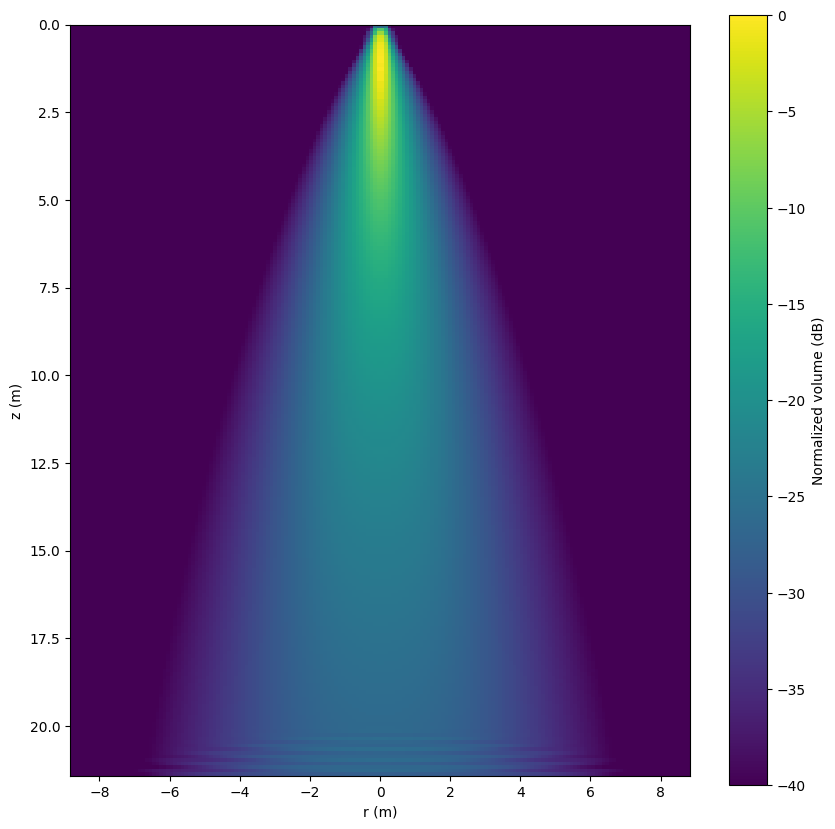

In [8]:
# freq_to_plot = 1*f0
freq_to_plot = 1*delta_f
# freq_to_plot = result.sources[0].frequency1
# freq_to_plot = 3e3
print(freq_to_plot)
idx = np.argmin(np.abs(frequencies - freq_to_plot))
lobes_selection = lobes_array[idx]
# print(frequencies[idx])

vmin = -40
vmax = 0
# vmin = 180
# vmax = 220
# vmin = 240
# vmax = 280
# vmin = 150
# vmax = 180
# vmin = None
# vmax = None
lobes_selection = 20*np.log10(lobes_selection/1e-6)
lobes_selection -= lobes_selection.max()

lobes_selection_mirrored = np.concatenate([np.flip(lobes_selection, axis=0), lobes_selection], axis=0)

plt.figure(figsize=(10, 10))
plt.imshow(lobes_selection_mirrored.T, extent=[-result.model.nrd * result.model.dr, result.model.nrd * result.model.dr, result.model.nzd * result.model.dz, 0], vmin=vmin, vmax=vmax)
cbar = plt.colorbar()
cbar.set_label("Normalized volume (dB)")
plt.xlabel("r (m)")
plt.ylabel("z (m)")

# print(lobes_selection.T[:,0])

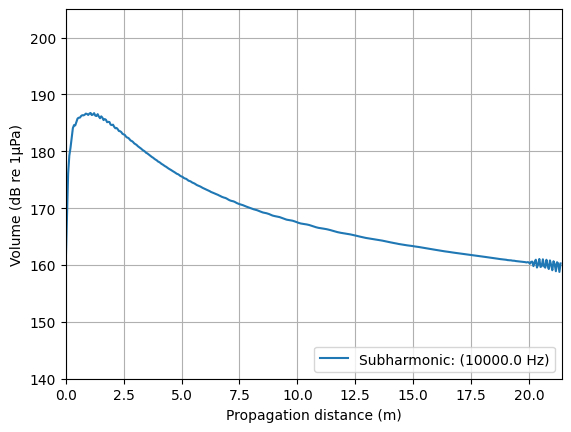

In [12]:
# Generate and plot harmonic progression
nrd = result.p.shape[1]
nzd = result.p.shape[2]
include_subharmonic = True
distances, harmonic_progression_array, harmonics = result.harmonic_progression(num_harmonics=0,
                                                         r_start=0,
                                                         z_start=0,
                                                         angle=0,
                                                         include_subharmonic=include_subharmonic,
                                                         subharmonic_freq=delta_f,
                                                         scaling_factor=result.sources[0].scaling_factor*result.subsample_time,
                                                         normalize=False)
if include_subharmonic:
    plt.plot(distances, harmonic_progression_array[0], label=f"Subharmonic: ({delta_f} Hz)")
    for i in range(1, harmonic_progression_array.shape[0]):
        plt.plot(distances, harmonic_progression_array[i], label=f"Harmonic {i}: ({harmonics[i]} Hz)")
else:
    for i in range(harmonic_progression_array.shape[0]):
        plt.plot(distances, harmonic_progression_array[i], label=f"Harmonic {i+1}: ({harmonics[i]} Hz)")

plt.xlabel("Propagation distance (m)")
# plt.ylabel("Normalized volume (dB)")
plt.ylabel("Volume (dB re 1\u03BCPa)")
# plt.ylim(-100,5)
# plt.ylim(160, 205)
plt.xlim(0, result.model.nzd*result.model.dz)
# plt.xlim(30,40)
plt.ylim(140, 205)
plt.grid()
# plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.legend(loc="lower right")
plt.show()

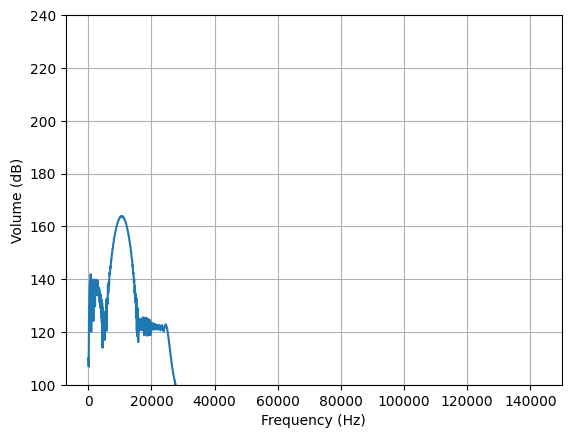

In [13]:
depth = 15  # m
ymin = 100
ymax = 240
# ymin = -100
# ymax = 5

r_index = 0
z_index = int(depth/result.model.dz/result.subsample_space)

plt.plot(*get_dB_response(np.pad(result.p[:, r_index, z_index], (0,0)), 
                          result.model.dt*result.subsample_time, 
                          result.sources[0].scaling_factor*result.subsample_time, 
                          normalize=False))
# plt.vlines(delta_f, ymin, ymax, "tab:blue", "--", alpha=1)

# colors = ["w", "tab:orange", "tab:green", "tab:red", "tab:purple"]
# for i in range(1,5):
#     plt.vlines(harmonics[i], ymin, ymax, colors[i], "--", alpha=1)


plt.xlabel("Frequency (Hz)")
# plt.ylabel("Normalized volume (dB)")
plt.ylabel("Volume (dB)")
# plt.xlim(0,4*result.sources[0].frequency1)
# plt.xlim(0,5.5*result.sources[0].frequency1)
# plt.xlim(0,5.5*10e3)
plt.ylim(ymin,ymax)
plt.grid()
plt.show()

In [14]:
save_to_file(result)